In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn import linear_model


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#random variation of parameters
def randpar(par,var):
    '''This function adds gaussian noise to parameters stored in a dictionary. 
    var is the std of the gaussian distribution (1 = 100% of the not noisy value).'''
    flag = 0
    while flag == 0:
        temp = cp.deepcopy(par)
        for key in par.keys():
            temp[key]=par[key]*(1+var*plb.randn())
            #if temp[key] < 0:
            #    flag = 0
            #    break
            #else:
                #flag =1
            if temp[key] < 0:
                temp[key] = 0
        flag = 1            
    return temp  

# 2D Lotka-Volterra Model

In [ ]:
#2D Lotka-Volterra
def LVder(x,t,p):
    der0 = p['a']*x[0] - p['b']*x[0]*x[1]
    der1 = -p['c']*x[1] + p['d']*x[0]*x[1]
    return [der0,der1]



LVpar = dict(a=0.4,b=0.4,c=0.1,d=0.2)

# Function to return trajectories

In [ ]:
# for fixed Delta t solve 300 trajectories
def traj_solve(N,dt,mod,mod_par,var):
    t0 = 0
    tend = 80
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        yinit = plb.rand(2)*array([0.5,1])
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time    

## Example

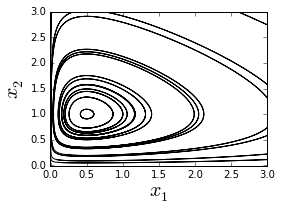

In [ ]:
N = 15
traj,time = traj_solve(N,0.1,LVder,LVpar,0.0)
figure(figsize=(4,3))
for i in range(N):
    plot(traj[i,:,0],traj[i,:,1],'k')
    xlabel("$x_1$",size='20')
    ylabel("$x_2$",size='20')
    xlim((-.01,3))
    ylim((-.01,3))

tight_layout()
savefig("ofd/2d_traj.pdf") 

In [ ]:
shape(traj)

(300, 1000, 2)

# trajectories to samples of f

In [ ]:
def traj_der(traj,time):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt
                
    return trajder            

In [ ]:
time[1]-time[0]

0.10010010010010011

## Example

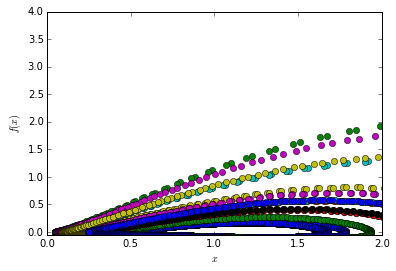

In [ ]:
trajder = traj_der(traj,time)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,2))
    ylim((-0.05,4))

# Scale and discretize measurments to fit on a 128x128 grid

In [ ]:
#convert discrete index to x1,x2 position in the model

#continuous scaling
#127 -> 2
#0 -> 0
def ind_to_x(i):
    return i*2./127.


In [ ]:
# convert x position to discrete index

#2 -> 255
#0 -> 0
def x_to_ind(x):
    ind = x/2.*127.
    return int(round(ind))    

In [ ]:
ind_to_x(x_to_ind(2.35))

2.3464566929133857

In [ ]:
def traj_to_f_meas(traj,trajder,jj):
    N,Nt,Nvar = np.shape(traj)
    f_meas = np.full((N,128,128),-100.)
    for k in range(N):
        for i in range(Nt-1):
            #make sure index fits into the 256 array
            if x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.) < 128 and x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.) < 128:
                f_meas[k,x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.),x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)] = trajder[k,i,jj]
    return f_meas       

def traj_to_f_m(traj,trajder,Ntraj,jj):
    N,Nt,Nvar = np.shape(traj)
    f_m = np.full((128,128),-100.)
    touched = np.full((128,128),0.)
    s = sorted(permutation(N)[:Ntraj])
    for k in s:
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            if  (ind0 < 128) and (ind1 < 128):
                if (ind0 >= 0) and (ind1 >= 0):
                    if touched[ind0,ind1] == 0.:
                        f_m[ind0,ind1] = trajder[k,i,jj]
                    else:    
                        f_m[ind0,ind1] += trajder[k,i,jj]
                        
                    touched[ind0,ind1] +=1.
                    
    for i in range(128):
        for j in range(128):
            if touched[i,j]!=0.:
                f_m[i,j]/=float(touched[i,j])
    return f_m

IndexError: index 15 is out of bounds for axis 0 with size 15

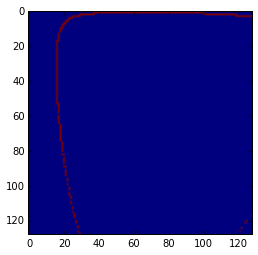

In [ ]:
f_meas = traj_to_f_meas(traj,trajder,0)
for i in range(21):
    imshow(f_meas[i])
#ylim((-.05,3))
#xlim((-1,256))

In [ ]:
traj.shape

(300, 1000, 2)

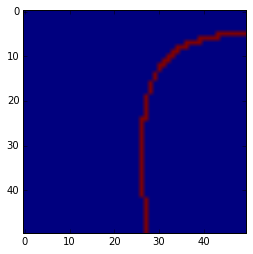

In [ ]:
imshow(f_meas[20][:50,:50])

# Sparsely reconstruct under-sampled data in basis

In [ ]:
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = True):
    clf = linear_model.Lasso(alpha=0.00001, copy_X=True, fit_intercept=False, max_iter=3000, tol=0.00000000001)

    #create array for reconstructed data
    recdata = np.full(data.shape,0.)
    
    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
            clf.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,clf.coef_)
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                print("not enough data!\n")
                #print(i)
                continue

        clf.fit(basis[:,rm].T, data[i,rm])
        #(3) reconstruct patch from fit coefficients
        recdata[i,:] = np.dot(basis.T,clf.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata

In [ ]:
def rec_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    from itertools import product as pd
    
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    touched = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, pd(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p
        touched[i:i + p_h, j:j + p_w] +=1

    #story checks out until here, I think    
    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            
            #img[i, j] /= float(min(i + 1, p_h, i_h - i) *
             #                  min(j + 1, p_w, i_w - j))
            img[i,j]/=float(touched[i,j])    
    return img

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = True):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    print(patch_size)
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    print("shape of data",data.shape)
    datarec = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = rec_from_patches_2d(datarec, imsize)
    return rec

# learn basis from data

In [ ]:
#number of trajectories to include
def f_prep(N,NTraj,f_meas,b_size):
    #start with a random basis
    r_basis = np.random.rand(100,b_size)

    #sample randomly from all trajectories
    s = sorted(permutation(N)[:NTraj])
    f_m = np.full((128,128),-100.)
    #for fixed (x1,x2) average over all trajectory measurements (only those values that are not -100)
    for i in range(128):
        for j in range(128):
            col = [f_meas[k,i,j] for k in s if f_meas[k,i,j]!= -100.]
            if col == []:
                f_m[i,j] = -100.
            else:
                f_m[i,j] = np.mean(col)
    return f_m,r_basis

In [ ]:
# learn basis, return reconstruction and basis
def basis_and_rec(f_m,init_basis):
    print("starting rec...")
    b_size = init_basis.shape
    b_s = int(np.sqrt(b_size[1]))
    #print(b_size)
    #reconstruct sparsely in random basis
    print("first rec in random basis")
    rec = image_rec(f_m,init_basis,1,b_s,b_s,real_data = True)
    
    tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.01, n_iter=1000 )
    # resize to basis size
    datarec = extract_patches_2d(rec,(b_s,b_s))
    datarec = datarec.reshape(datarec.shape[0], -1)
    print("learning basis")
    V = tempdic.fit(datarec).components_
    print("second rec, in learned basis")
    rec = image_rec(f_m,V,1,b_s,b_s,real_data = True)
    
    return V,rec

# measure Error

In [ ]:
def norm_1(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)
    if np.linalg.norm(r)!=0.:
        norm = 1. - abs(np.dot(d,r))/np.linalg.norm(d)/np.linalg.norm(r)
    else:
        norm = 1. 
    return norm

def norm_2(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)
    return norm

def norm_3(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)/np.linalg.norm(d)
    return norm

# Running Script

In [ ]:
#create reference function f_ref
f_ref = np.full((128,128),0.)
for i in range(128):
    for j in range(128):
        f_ref[i,j] = LVder([ind_to_x(i),ind_to_x(j)],1,LVpar)[0]
# generate trajectories
traj,time = traj_solve(500,0.1,LVder,LVpar,0.0)        
#generate derivatives
trajder = traj_der(traj,time)
#rescale to sample f
f_meas = traj_to_f_meas(traj,trajder,0)

//anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
Ntraj = 200
b_size = 20*20
f_m,r_basis = f_prep(500,Ntraj,f_meas,b_size)

In [ ]:
V,rec = basis_and_rec(f_m[ind1:ind1+50,ind2:ind2+50],r_basis)

starting rec...
first rec in random basis
(20, 20)
shape of data (961, 400)
learning basis

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':



second rec, in learned basis
(20, 20)
shape of data (961, 400)


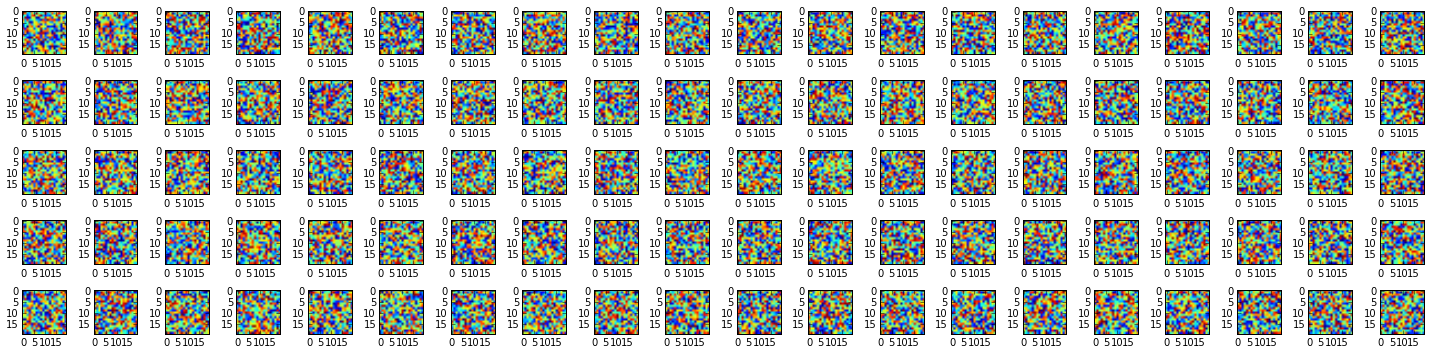

In [ ]:
figure(figsize=(20,5))
for i,comp in enumerate(r_basis):
    subplot(5,20,i+1)
    imshow(reshape(comp,(20,20)))
tight_layout()    

In [ ]:
V.shape

(30, 25)

0.0392288523658


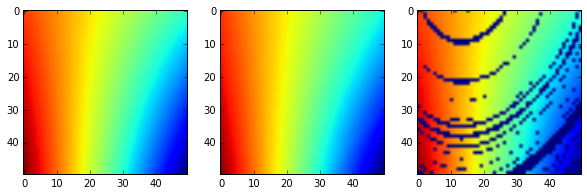

In [ ]:
f_refr = f_ref[ind1:ind1+50,ind2:ind2+50]
f_mr = f_m[ind1:ind1+50,ind2:ind2+50]

vmin = np.min(f_refr)
vmax = np.max(f_refr)
figure(figsize=(10,3))
subplot(1,3,1)
imshow(f_refr,vmax=vmax,vmin=vmin)
subplot(1,3,2)
imshow(rec,vmax=vmax,vmin=vmin)
subplot(1,3,3)
imshow(f_mr,vmax=vmax,vmin=vmin)#,vmax=vmax,vmin=vmin)
print(norm_3(f_refr,rec))

In [ ]:
print(norm_1(f_refr,rec),norm_2(f_refr,rec),norm_3(f_refr,rec))

0.000460883285206 0.226469422858 0.0392288523658


0.0


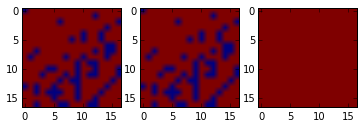

In [ ]:
rec = rec_from_patches_2d(extract_patches_2d(f_m[100:117,100:117],(16,16)),(17,17))
vmin = np.min(f_m[100:117,100:117])
vmax = np.max(f_m[100:117,100:117])
subplot(1,3,1)
imshow(f_m[100:117,100:117],vmin=vmin,vmax=vmax)
subplot(1,3,2)
imshow(rec,vmin=vmin,vmax=vmax)
subplot(1,3,3)
imshow(f_m[100:117,100:117]-rec,vmin=vmin,vmax=vmax)
print(np.sum(f_m[100:117,100:117]-rec))

In [ ]:
from itertools import product as pd
test = f_m[100:117,100:117]
[(i,j) for i,j in pd(range(17),range(17)) if rec[i,j]%-100. ==0] == \
[(i,j) for i,j in pd(range(17),range(17)) if test[i,j]%-100. ==0]

True

In [ ]:
f_ref = np.full((128,128),0.)
for i in range(128):
    for j in range(128):
        f_ref[i,j] = LVder([ind_to_x(i),ind_to_x(j)],1,LVpar)[0]
        
        
Nave = 20
dt_list = [0.01,0.1,1,5]
Ntraj_list = [5,10,20,50,100,200,500]
b_size_list = [20*20]#,8*8,10*10,16*16]#,20*20,32*32]
res = np.full((len(Ntraj_list)*len(b_size_list)*len(dt_list),6),0.)   
k = -1
for b_size in b_size_list:
    for dt in dt_list:#:
        # generate trajectories
        traj,time = traj_solve(500,dt,LVder,LVpar,0.0)
        #generate derivatives
        trajder = traj_der(traj,time)
        #rescale to sample f
        f_meas = traj_to_f_meas(traj,trajder,0)


        #sample NTraj trajectories
        for Ntraj in Ntraj_list:
            print('dt = '+str(dt))
            print('Ntraj = '+str(Ntraj))
            t_rec = np.full((Nave,3),0.)
            k+=1
            for i in range(Nave):
                r_basis = np.random.rand(100,b_size)
                f_m = traj_to_f_m(traj,trajder,Ntraj,0)

                # select random 50 by 50 frame for learning and reconstruction
                ind1 = round(np.random.rand()*78)
                ind2 = round(np.random.rand()*78)
                f_mr = f_m[ind1:ind1+50,ind2:ind2+50]
                f_refr = f_ref[ind1:ind1+50,ind2:ind2+50]
                
                # learn basis and reconstruct
                V,rec = basis_and_rec(f_mr,r_basis)
                t_rec[i]=[norm_1(f_refr,rec),norm_2(f_refr,rec),norm_3(f_refr,rec)]
                
            res[k,:3] = [dt,Ntraj,b_size]
            res[k,3:]= np.mean(t_rec,0)
np.savetxt("2d_err_dt_Ntraj2_new.txt",res)                

dt = 0.01
Ntraj = 5
starting rec...
first rec in random basis
(20, 20)
shape of data (961, 400)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not 

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)



not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

not enoug

In [ ]:
#np.savetxt("2d_err_dt_Ntraj.txt",res[:24,:])

# Data analysis

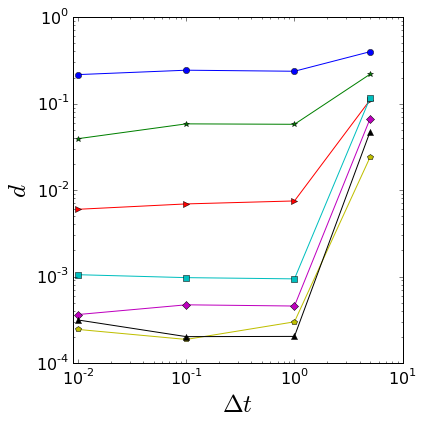

In [ ]:
err = np.loadtxt("2d_err_dt_Ntraj2_new.txt")

symb = ['o-','*-','>-','s-','D-','p-','^-']
figure(figsize = (6,6))
for k,i in enumerate(np.unique(err[:,1])):
    l = [j for j in range(len(err[:,0])) if (err[j,1]==i and err[j,2]==400)]
    plot(err[l,0],err[l,3],symb[k],label = "$N_{traj}$ = "+str(int(i)))
    #legend(loc=4)
    xscale('log')
    xlim(0.009,10)
    yscale('log')
    xlabel('$\Delta t$',size = '25')
    ylabel('$d$',size = '25')
#ylim(-0.001,0.008)
tick_params(axis='both', which='major', labelsize=16)
    
tight_layout()
savefig("ofd/2d_err_vs_dt.pdf")

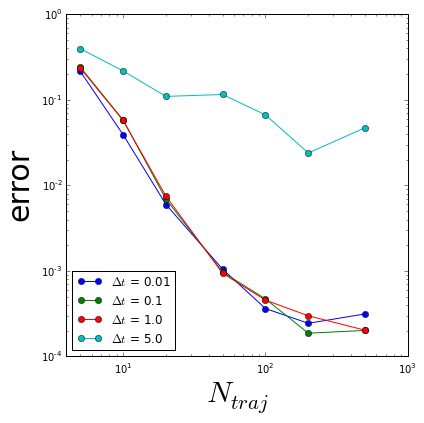

In [ ]:
figure(figsize = (6,6))
for i in np.unique(err[:,0]):
    l = [j for j in range(len(err[:,0])) if (err[j,0]==i and err[j,2]==400)]
    plot(err[l,1],err[l,3],'o-',label = "$\Delta t$ = "+str(i))
    legend(loc=3)
    xscale('log')
    xlim(4,1000)
    yscale('log')
    xlabel('$N_{traj}$',size = '30')
    ylabel('error',size = '30')
    #ylim(0,0.01)
    
tight_layout()
#savefig("2d_err_vs_Ntraj.pdf")

# Find optimal basis size

In [ ]:
Nave = 10
dt_list = [0.1]
Ntraj_list = [200]
b_size_list = [5*5,8*8,10*10,12*12,16*16,20*20,32*32]
res = np.full((len(Ntraj_list)*len(b_size_list)*len(dt_list),6),0.)   
k = -1
for b_size in b_size_list:
    for dt in dt_list:#:
        # generate trajectories
        traj,time = traj_solve(200,0.1,LVder,LVpar,0.0)
        #generate derivatives
        trajder = traj_der(traj,time)
        #rescale to sample f
        f_meas = traj_to_f_meas(traj,trajder,0)


        #sample NTraj trajectories
        for Ntraj in Ntraj_list:
            print('dt = '+str(dt))
            print('Ntraj = '+str(Ntraj))
            t_rec = np.full((Nave,3),0.)
            k+=1
            for i in range(Nave):
                f_m,r_basis = f_prep(200,Ntraj,f_meas,b_size)

                # select random 50 by 50 frame for learning and reconstruction
                ind1 = round(np.random.rand()*78)
                ind2 = round(np.random.rand()*78)
                f_mr = f_m[ind1:ind1+50,ind2:ind2+50]
                f_refr = f_ref[ind1:ind1+50,ind2:ind2+50]
                
                # learn basis and reconstruct
                V,rec = basis_and_rec(f_mr,r_basis)
                t_rec[i]=[norm_1(f_refr,rec),norm_2(f_refr,rec),norm_3(f_refr,rec)]
                
            res[k,:3] = [dt,Ntraj,b_size]
            res[k,3:]= np.mean(t_rec,0)
np.savetxt("2d_err_vs_b_size.txt",res)   

dt = 0.1
Ntraj = 200
starting rec...
first rec in random basis
(5, 5)
shape of data (2116, 25)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

learning basis

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':



second rec, in learned basis
(5, 5)
shape of data (2116, 25)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

starting rec...
first rec in random basis
(5, 5)
shape of data (2116, 25)
not enough data!

learning basis
second rec, in learned basis
(5, 5)
shape of data (2116, 25)
not enough data!

starting rec...
first rec in random basis
(5, 5)
shape of data (2116, 25)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

learning basis
second rec, in learned basis
(5, 5)
shape of data (2116, 25)
not enough data!

not enough data!

not enough data!

not enough data!

not enough data!

starting rec...
first rec in random basis
(5, 5)
shape of data (2116, 25)
learning basis
second rec, in learned basis
(5, 5)
shape of data (2116, 25)
starting rec...
first rec in random basis
(5, 5)
shape of data (2116, 25)
learning basis
second rec, in learned basis
(5, 5)
shape of data (2116, 25)
starting rec...
first rec in ran

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


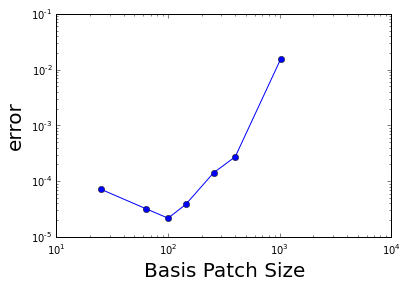

In [ ]:
err_bs = np.loadtxt("2d_err_vs_b_size.txt")

plot(err_bs[:,2],err_bs[:,3],'o-')
legend()
xscale('log')
xlabel('Basis Patch Size',size = '20')
ylabel('error',size = '20')
yscale('log')
savefig("2d_err_vs_b_size.pdf")

In [ ]:
1+1

2

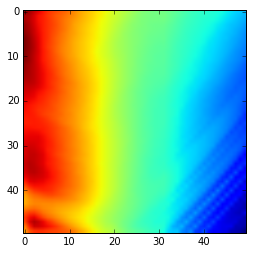

In [ ]:
imshow(rec)

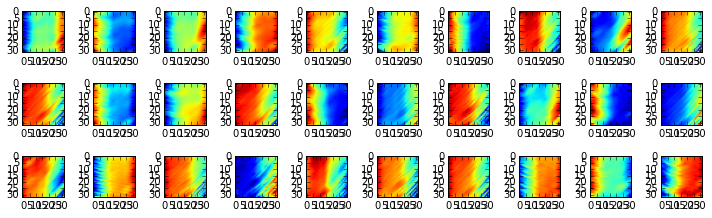

In [ ]:
figure(figsize=(10,10))
for i,comp in enumerate(V):
    subplot(10,10,i+1)
    imshow(reshape(comp,(32,32)))
tight_layout()   